In [ ]:
import music21
import pathlib

from thesession.converter import ABCMusicConverter

In [ ]:
ABCMusicConverter("cooleys.abc", "cooleys").to_mp3(
    instrument="flute",
    tempo=190,
    max_notes=300,
    cut_silence=30,
    start=0.57,
    noise_amplitude=0.001,
    duration=120,
    vbr=8,
    clean_files=True,
)

# CLAP

In [ ]:
import torch
from laion_clap import CLAP_Module

# Load pretrained CLAP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CLAP_Module(enable_fusion=True)  # For using fusion to manage >10s clips
model.load_ckpt()  # downloads pretrained weights
model = model.to(device)

/home/maxime/.venvs/session/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/maxime/.venvs/session/lib64/python3.11/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4314.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Load our best checkpoint in the paper.
The checkpoint is already downloaded
Load Checkpoint...
logit_scale_a 	 Loaded
logit_scale_t 	 Loaded
audio_branch.spectrogram_extractor.stft.conv_real.weight 	 Loaded
audio_branch.spectrogram_extractor.stft.conv_imag.weight 	 Loaded
audio_branch.logmel_extractor.melW 	 Loaded
audio_branch.bn0.weight 	 Loaded
audio_branch.bn0.bias 	 Loaded
audio_branch.patch_embed.proj.weight 	 Loaded
audio_branch.patch_embed.proj.bias 	 Loaded
audio_branch.patch_embed.norm.weight 	 Loaded
audio_branch.patch_embed.norm.bias 	 Loaded
audio_branch.patch_embed.mel_conv2d.weight 	 Loaded
audio_branch.patch_embed.mel_conv2d.bias 	 Loaded
audio_branch.patch_embed.fusion_model.local_att.0.weight 	 Loaded
audio_branch.patch_embed.fusion_model.local_att.0.bias 	 Loaded
audio_branch.patch_embed.fusion_model.local_att.1.weight 	 Loaded
audio_branch.patch_embed.fusion_model.local_att.1.bias 	 Loaded
audio_branch.patch_embed.fusion_model.local_att.3.weight 	 Loaded
audio_branc

In [11]:
import torchaudio

waveform, sr = torchaudio.load("cooleys.mp3")

In [12]:
import torchaudio
import torch


def load_audio(filepath, target_sr=16000):
    waveform, sr = torchaudio.load(filepath)
    if sr != target_sr:
        waveform = torchaudio.functional.resample(waveform, sr, target_sr)
    return waveform.mean(dim=0).unsqueeze(0)  # Convert to mono, add batch dim

In [13]:
audio_tensor0 = load_audio("audio/1_cooleys/36371_0.mp3")
audio_tensor1 = load_audio("audio/1_cooleys/36371_1.mp3")
audio_tensor2 = load_audio("audio/8_the_banshee/32846_0.mp3")
audio_tensor3 = load_audio("audio/8_the_banshee/32846_1.mp3")

In [14]:
with torch.no_grad():
    embedding0 = model.get_audio_embedding_from_data(audio_tensor0, use_tensor=True)
    embedding1 = model.get_audio_embedding_from_data(audio_tensor1, use_tensor=True)
    embedding2 = model.get_audio_embedding_from_data(audio_tensor2, use_tensor=True)
    embedding3 = model.get_audio_embedding_from_data(audio_tensor3, use_tensor=True)

/home/maxime/.venvs/session/lib64/python3.11/site-packages/torchaudio/transforms/_transforms.py:580: UserWarning: Argument 'onesided' has been deprecated and has no influence on the behavior of this module.
  warnings.warn(


In [15]:
embeddings = torch.cat([embedding0, embedding1, embedding2, embedding3], dim=0)
embeddings.shape

torch.Size([4, 512])

In [16]:
import torch.nn.functional as F

F.cosine_similarity(embeddings[None, :, :], embeddings[:, None, :], dim=-1)

tensor([[1.0000, 0.8502, 0.8558, 0.8473],
        [0.8502, 1.0000, 0.9414, 0.8412],
        [0.8558, 0.9414, 1.0000, 0.8524],
        [0.8473, 0.8412, 0.8524, 1.0000]], device='cuda:0')

# Dataset

In [1]:
import pathlib
import numpy as np
import pandas as pd

from thesession.dataset import TheSessionDataset

path = pathlib.Path("audio_flac")
tunes = [p.stem for p in path.iterdir() if p.is_dir()]
tunes.sort()

tunes_df = pd.DataFrame({"tune": tunes.copy(), "dataset": None})

prng = np.random.default_rng(42)
tunes = prng.permutation(tunes)

tunes_df.loc[tunes_df["tune"].isin(tunes[0 : int(0.15 * len(tunes))]), "dataset"] = (
    "test"
)
tunes_df.loc[
    tunes_df["tune"].isin(tunes[int(0.15 * len(tunes)) : int(0.3 * len(tunes))]),
    "dataset",
] = "validation"
tunes_df.loc[tunes_df["tune"].isin(tunes[int(0.3 * len(tunes)) :]), "dataset"] = "train"


tunes_df.to_csv("dataset.csv")

In [2]:
test_subset = tunes_df.loc[tunes_df["dataset"] == "test", "tune"]
val_subset = tunes_df.loc[tunes_df["dataset"] == "validation", "tune"]
train_subset = tunes_df.loc[tunes_df["dataset"] == "train", "tune"]

train_dataset = TheSessionDataset(
    "audio_flac", subset=train_subset, sampling_rate=48000, fmt=".flac"
)
val_dataset = TheSessionDataset(
    "audio_flac", subset=val_subset, sampling_rate=48000, fmt=".flac"
)
test_dataset = TheSessionDataset(
    "audio_flac", subset=test_subset, sampling_rate=48000, fmt=".flac"
)

print("Training data", len(train_dataset))
print("Validation data", len(val_dataset))
print("Test data", len(test_dataset))

Training data 26344
Validation data 5534
Test data 5728


In [3]:
train_dataset[32]

(tensor([-0.0138, -0.0157, -0.0151,  ..., -0.0132, -0.0090, -0.0040]),
 tensor([ 0.0086,  0.0108,  0.0123,  ..., -0.0052, -0.0035, -0.0016]))

In [4]:
train_dataset[32][0].max()

tensor(0.0609)

In [5]:
train_dataset[32][0].min()

tensor(-0.0386)

In [6]:
%%timeit

train_dataset[0]

47 ms ± 3.97 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [7]:
import torch

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=16, shuffle=True, num_workers=4
)

In [8]:
import time

start = time.perf_counter()

for i, (x1, x2) in enumerate(train_loader):
    if i < 20:
        print(i, end="\r")
    else:
        break

end = time.perf_counter()
print("Duration: ", end - start)

Duration:  8.030320544996357


# Model

In [46]:
from thesession.model import TheSessionModel

model = TheSessionModel()
model.load_ckpt()

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Load our best checkpoint in the paper.
The checkpoint is already downloaded
Load Checkpoint...
logit_scale_a 	 Loaded
logit_scale_t 	 Loaded
audio_branch.spectrogram_extractor.stft.conv_real.weight 	 Loaded
audio_branch.spectrogram_extractor.stft.conv_imag.weight 	 Loaded
audio_branch.logmel_extractor.melW 	 Loaded
audio_branch.bn0.weight 	 Loaded
audio_branch.bn0.bias 	 Loaded
audio_branch.patch_embed.proj.weight 	 Loaded
audio_branch.patch_embed.proj.bias 	 Loaded
audio_branch.patch_embed.norm.weight 	 Loaded
audio_branch.patch_embed.norm.bias 	 Loaded
audio_branch.patch_embed.mel_conv2d.weight 	 Loaded
audio_branch.patch_embed.mel_conv2d.bias 	 Loaded
audio_branch.patch_embed.fusion_model.local_att.0.weight 	 Loaded
audio_branch.patch_embed.fusion_model.local_att.0.bias 	 Loaded
audio_branch.patch_embed.fusion_model.local_att.1.weight 	 Loaded
audio_branch.patch_embed.fusion_model.local_att.1.bias 	 Loaded
audio_branch.patch_embed.fusion_model.local_att.3.weight 	 Loaded
audio_branc

In [47]:
model.toggle_gradients(False)

Disabling gradient for parameter clap_model.model.logit_scale_a
Disabling gradient for parameter clap_model.model.logit_scale_t
Disabling gradient for parameter clap_model.model.audio_branch.spectrogram_extractor.stft.conv_real.weight
Disabling gradient for parameter clap_model.model.audio_branch.spectrogram_extractor.stft.conv_imag.weight
Disabling gradient for parameter clap_model.model.audio_branch.logmel_extractor.melW
Disabling gradient for parameter clap_model.model.audio_branch.bn0.weight
Disabling gradient for parameter clap_model.model.audio_branch.bn0.bias
Disabling gradient for parameter clap_model.model.audio_branch.patch_embed.proj.weight
Disabling gradient for parameter clap_model.model.audio_branch.patch_embed.proj.bias
Disabling gradient for parameter clap_model.model.audio_branch.patch_embed.norm.weight
Disabling gradient for parameter clap_model.model.audio_branch.patch_embed.norm.bias
Disabling gradient for parameter clap_model.model.audio_branch.patch_embed.mel_conv

In [48]:
model.toggle_gradients(True, ["clap_model.model.audio_projection"])

Enabling gradient for parameter clap_model.model.audio_projection.0.weight
Enabling gradient for parameter clap_model.model.audio_projection.0.bias
Enabling gradient for parameter clap_model.model.audio_projection.2.weight
Enabling gradient for parameter clap_model.model.audio_projection.2.bias


In [49]:
model

TheSessionModel(
  (clap_model): CLAP_Module(
    (model): CLAP(
      (audio_branch): HTSAT_Swin_Transformer(
        (spectrogram_extractor): Spectrogram(
          (stft): STFT(
            (conv_real): Conv1d(1, 513, kernel_size=(1024,), stride=(480,), bias=False)
            (conv_imag): Conv1d(1, 513, kernel_size=(1024,), stride=(480,), bias=False)
          )
        )
        (logmel_extractor): LogmelFilterBank()
        (spec_augmenter): SpecAugmentation(
          (time_dropper): DropStripes()
          (freq_dropper): DropStripes()
        )
        (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (patch_embed): PatchEmbed(
          (proj): Conv2d(1, 96, kernel_size=(4, 4), stride=(4, 4))
          (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (mel_conv2d): Conv2d(1, 96, kernel_size=(4, 12), stride=(4, 12))
          (fusion_model): AFF(
            (local_att): Sequential(
              (0): Conv2d(96,

# Tests

## Tests sur les mini-batchs

In [ ]:
import pandas as pd

from thesession.dataset import TheSessionDataset
from thesession.model import TheSessionModel
from thesession.training import eval_model, NTXentLoss

# Dataset
dataset = pd.read_csv("dataset.csv")

test_subset = dataset.loc[dataset["dataset"] == "test", "tune"]

test_dataset = TheSessionDataset(
    "audio_flac", subset=test_subset, sampling_rate=48000, fmt=".flac"
)

model = TheSessionModel(device="cuda")
criterion = NTXentLoss(temperature=0.05)
model.eval()

with open("testing/testing.csv", "w") as f:
    f.write("\nstep,test_loss,test_accuracy")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Baseline
loss, acc = eval_model(model, test_dataset, criterion, "cuda", num_workers=6)

with open("testing/testing.csv", "a") as f:
    f.write(f"\nbaseline,{loss},{acc}")

/home/maxime/.venvs/session/lib64/python3.11/site-packages/torchaudio/transforms/_transforms.py:580: UserWarning: Argument 'onesided' has been deprecated and has no influence on the behavior of this module.
  warnings.warn(


Duration of evaluation on test data: 74.80 seconds
Test Loss: 4.1359 | Test Accuracy: 0.0341 | 


In [ ]:
# Pretrained weights
model.load_ckpt()
loss, acc = eval_model(model, test_dataset, criterion, "cuda", num_workers=6)

with open("testing/testing.csv", "a") as f:
    f.write(f"\npretrain,{loss},{acc}")

Load our best checkpoint in the paper.
The checkpoint is already downloaded
Load Checkpoint...
logit_scale_a 	 Loaded
logit_scale_t 	 Loaded
audio_branch.spectrogram_extractor.stft.conv_real.weight 	 Loaded
audio_branch.spectrogram_extractor.stft.conv_imag.weight 	 Loaded
audio_branch.logmel_extractor.melW 	 Loaded
audio_branch.bn0.weight 	 Loaded
audio_branch.bn0.bias 	 Loaded
audio_branch.patch_embed.proj.weight 	 Loaded
audio_branch.patch_embed.proj.bias 	 Loaded
audio_branch.patch_embed.norm.weight 	 Loaded
audio_branch.patch_embed.norm.bias 	 Loaded
audio_branch.patch_embed.mel_conv2d.weight 	 Loaded
audio_branch.patch_embed.mel_conv2d.bias 	 Loaded
audio_branch.patch_embed.fusion_model.local_att.0.weight 	 Loaded
audio_branch.patch_embed.fusion_model.local_att.0.bias 	 Loaded
audio_branch.patch_embed.fusion_model.local_att.1.weight 	 Loaded
audio_branch.patch_embed.fusion_model.local_att.1.bias 	 Loaded
audio_branch.patch_embed.fusion_model.local_att.3.weight 	 Loaded
audio_branc

In [ ]:
model.load("models/step1_best.pt")
loss, acc = eval_model(model, test_dataset, criterion, "cuda", num_workers=6)

with open("testing/testing.csv", "a") as f:
    f.write(f"\nstep1,{loss},{acc}")

/home/maxime/.venvs/session/lib64/python3.11/site-packages/torchaudio/transforms/_transforms.py:580: UserWarning: Argument 'onesided' has been deprecated and has no influence on the behavior of this module.
  warnings.warn(


Duration of evaluation on test data: 78.11 seconds
Test Loss: 1.3578 | Test Accuracy: 0.8547 | 


In [ ]:
model.load("models/step2_best.pt")
loss, acc = eval_model(model, test_dataset, criterion, "cuda", num_workers=6)

with open("testing/testing.csv", "a") as f:
    f.write(f"\nstep2,{loss},{acc}")

/home/maxime/.venvs/session/lib64/python3.11/site-packages/torchaudio/transforms/_transforms.py:580: UserWarning: Argument 'onesided' has been deprecated and has no influence on the behavior of this module.
  warnings.warn(


Duration of evaluation on test data: 78.51 seconds
Test Loss: 1.1881 | Test Accuracy: 0.9027 | 


In [ ]:
model.load("models/step3_best.pt")
loss, acc = eval_model(model, test_dataset, criterion, "cuda", num_workers=6)

with open("testing/testing.csv", "a") as f:
    f.write(f"\nstep3,{loss},{acc}")

/home/maxime/.venvs/session/lib64/python3.11/site-packages/torchaudio/transforms/_transforms.py:580: UserWarning: Argument 'onesided' has been deprecated and has no influence on the behavior of this module.
  warnings.warn(


Duration of evaluation on test data: 79.59 seconds
Test Loss: 0.3228 | Test Accuracy: 0.9064 | 


In [ ]:
model.load("models/step4_best.pt")
loss, acc = eval_model(model, test_dataset, criterion, "cuda", num_workers=6)

with open("testing/testing.csv", "a") as f:
    f.write(f"\nstep4,{loss},{acc}")

/home/maxime/.venvs/session/lib64/python3.11/site-packages/torchaudio/transforms/_transforms.py:580: UserWarning: Argument 'onesided' has been deprecated and has no influence on the behavior of this module.
  warnings.warn(


Duration of evaluation on test data: 81.44 seconds
Test Loss: 0.1336 | Test Accuracy: 0.9642 | 


In [ ]:
model.load("models/step5_best.pt")
loss, acc = eval_model(model, test_dataset, criterion, "cuda", num_workers=6)

with open("testing/testing.csv", "a") as f:
    f.write(f"\nstep5,{loss},{acc}")

/home/maxime/.venvs/session/lib64/python3.11/site-packages/torchaudio/transforms/_transforms.py:580: UserWarning: Argument 'onesided' has been deprecated and has no influence on the behavior of this module.
  warnings.warn(


Duration of evaluation on test data: 82.40 seconds
Test Loss: 0.0949 | Test Accuracy: 0.9745 | 


In [ ]:
model.load("models/step6_best.pt")
loss, acc = eval_model(model, test_dataset, criterion, "cuda", num_workers=6)

with open("testing/testing.csv", "a") as f:
    f.write(f"\nstep6,{loss},{acc}")

/home/maxime/.venvs/session/lib64/python3.11/site-packages/torchaudio/transforms/_transforms.py:580: UserWarning: Argument 'onesided' has been deprecated and has no influence on the behavior of this module.
  warnings.warn(


Duration of evaluation on test data: 81.96 seconds
Test Loss: 0.0393 | Test Accuracy: 0.9911 | 


In [69]:
import matplotlib.pyplot as plt

plt.rcParams["axes.autolimit_mode"] = "round_numbers"

batch_testing = pd.read_csv("testing/testing.csv", index_col=0)
batch_testing

,test_loss,test_accuracy
step,,
baseline,4.135856,0.034131
pretrain,5.588309,0.009427
step1,1.357777,0.854661
step2,1.188111,0.902671
step3,0.322795,0.906425
step4,0.133599,0.964211
step5,0.094859,0.974511
step6,0.039318,0.991096


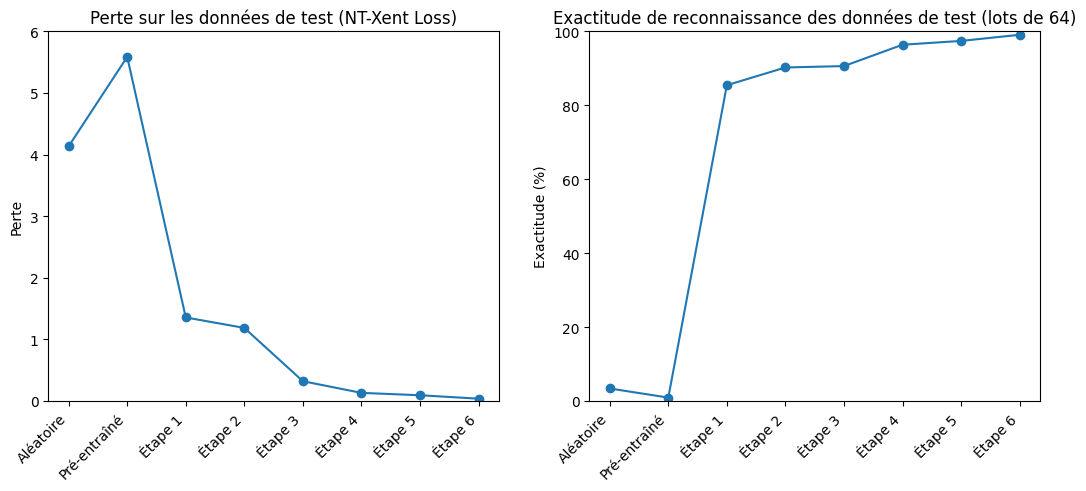

In [74]:
fig, axes = plt.subplots(1, 2, figsize=(12.8, 4.8))

labels = [
    "Aléatoire",
    "Pré-entraîné",
    "Étape 1",
    "Étape 2",
    "Étape 3",
    "Étape 4",
    "Étape 5",
    "Étape 6",
]

ax = axes[0]
ax.plot(batch_testing["test_loss"], marker="o")
ax.set_ylim(0, None)
ax.set_ylabel("Perte")
ax.set_xticks(range(len(batch_testing)), labels, rotation=45, ha="right")
ax.set_title("Perte sur les données de test (NT-Xent Loss)")

ax = axes[1]
ax.plot(100 * batch_testing["test_accuracy"], marker="o")
ax.set_ylim(0, 100)
ax.set_ylabel("Exactitude (%)")
ax.set_xticks(range(len(batch_testing)), labels, rotation=45, ha="right")
ax.set_title("Exactitude de reconnaissance des données de test (lots de 64)")

fig.savefig("testing/test_results.png", dpi=300, bbox_inches="tight")

## Tests sur la base de données complète

In [45]:
import os
import dotenv
import pathlib

import pandas as pd

from thesession.retriever import TheSessionRetriever, get_database_url

dotenv.load_dotenv("thesession-db/.env")

url = get_database_url(
    os.getenv("POSTGRES_USER"),
    os.getenv("POSTGRES_PASSWORD"),
    port=15432,
    database=os.getenv("POSTGRES_DB"),
)

retriever = TheSessionRetriever(url, "models/step6_best.pt", backend="soundfile")

# Dataset
dataset = pd.read_csv("dataset.csv")

test_subset = dataset.loc[dataset["dataset"] == "test", "tune"]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [58]:
correct_tune_top1 = 0
correct_tune_top5 = 0
correct_tune_top10 = 0
correct_version_top1 = 0
correct_version_top5 = 0
correct_version_top10 = 0

denom = 0

root = pathlib.Path("audio_flac")

for i, tune in enumerate(test_subset[:100]):
    # Fetch tune id from directory
    tune_id = int(tune.split("_")[0])

    # Iterate over files in directory
    for file in (root / tune).iterdir():
        tune_version_id = int(file.stem.split("_")[0])

        # Get results from retriever
        results = retriever(file, limit=10, duration=60)

        # Add to denominator
        denom += 1

        # Check if the correct tune is identified
        tune_results = results["TuneID"].to_list()

        if tune_id in tune_results[:1]:
            correct_tune_top1 += 1
            correct_tune_top5 += 1
            correct_tune_top10 += 1
        elif tune_id in tune_results[1:5]:
            correct_tune_top5 += 1
            correct_tune_top10 += 1
        elif tune_id in tune_results[5:10]:
            correct_tune_top10 += 1

        # Check if the correct tune version is identified
        version_results = results["TuneVersionID"].to_list()

        if tune_version_id in version_results[:1]:
            correct_version_top1 += 1
            correct_version_top5 += 1
            correct_version_top10 += 1
        elif tune_version_id in version_results[1:5]:
            correct_version_top5 += 1
            correct_version_top10 += 1
        elif tune_version_id in version_results[5:10]:
            correct_version_top10 += 1

    print(f"Test {i+1}/{len(test_subset)}", end="\r")

accuracy = (
    pd.DataFrame(
        {
            "TuneAccuracy": [correct_tune_top1, correct_tune_top5, correct_tune_top10],
            "VersionAccuracy": [
                correct_version_top1,
                correct_version_top5,
                correct_version_top10,
            ],
        },
        index=["top1", "top5", "top10"],
    )
    / denom
)

accuracy

,TuneAccuracy,VersionAccuracy
top1,0.878505,0.795327
top5,0.954206,0.942056
top10,0.971028,0.963551


In [75]:
import matplotlib.pyplot as plt

plt.rcParams["axes.autolimit_mode"] = "round_numbers"

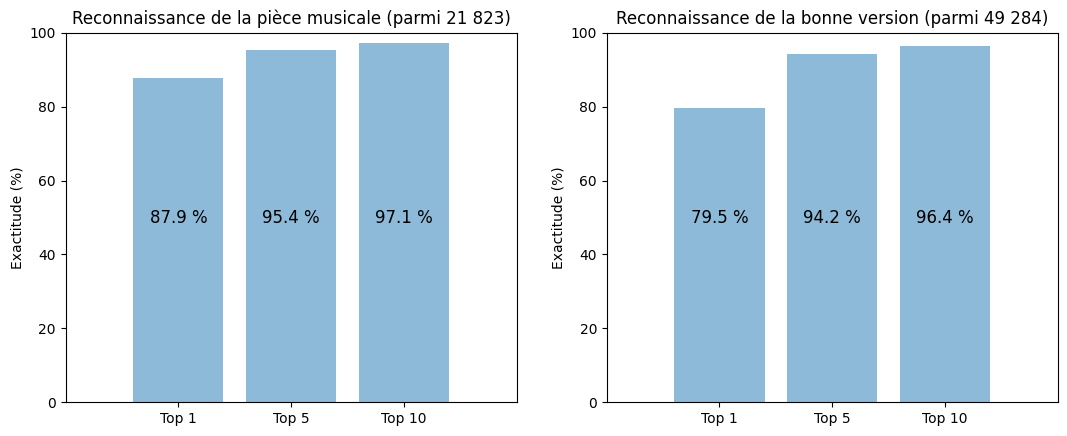

In [88]:
fig, axes = plt.subplots(1, 2, figsize=(12.8, 4.8))

labels = ["Top 1", "Top 5", "Top 10"]

ax = axes[0]
ax.bar(range(3), 100 * accuracy["TuneAccuracy"], alpha=0.5)

for i, acc in enumerate(accuracy["TuneAccuracy"]):
    ax.text(i, 50, f"{100 * acc:0.1f} %", va="center", ha="center", fontsize=12)

ax.set_ylim(0, 100)
ax.set_ylabel("Exactitude (%)")
ax.set_xticks(range(3), labels)
ax.set_title("Reconnaissance de la pièce musicale (parmi 21 823)")

ax = axes[1]
ax.bar(range(3), 100 * accuracy["VersionAccuracy"], alpha=0.5)

for i, acc in enumerate(accuracy["VersionAccuracy"]):
    ax.text(i, 50, f"{100 * acc:0.1f} %", va="center", ha="center", fontsize=12)

ax.set_ylim(0, 100)
ax.set_ylabel("Exactitude (%)")
ax.set_xticks(range(3), labels)
ax.set_title("Reconnaissance de la bonne version (parmi 49 284)")

fig.savefig("testing/final_test.png", dpi=300, bbox_inches="tight")

# Retriever

In [62]:
import os
import dotenv

import pandas as pd

from thesession.retriever import TheSessionRetriever, get_database_url

dotenv.load_dotenv("thesession-db/.env")

url = get_database_url(
    os.getenv("POSTGRES_USER"),
    os.getenv("POSTGRES_PASSWORD"),
    port=15432,
    database=os.getenv("POSTGRES_DB"),
)

retriever = TheSessionRetriever(url, "models/step6_best.pt", backend="soundfile")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [63]:
retriever("audio_flac/1_cooleys/36371_0.flac", limit=10, duration=60)

/home/maxime/.venvs/session/lib64/python3.11/site-packages/torchaudio/transforms/_transforms.py:580: UserWarning: Argument 'onesided' has been deprecated and has no influence on the behavior of this module.
  warnings.warn(


,TuneID,TuneVersionID,TuneTitle,TuneAuthor,TuneURL,TuneType,Tunebooks,TuneVersion,Similarity
0,1,36384,Cooley’s,None,https://thesession.org/tunes/1,reel,6090,X: 14\nT: Cooley's\nR: reel\nM: 4/4\nL: 1/8\nK...,0.940799
1,1,36371,Cooley’s,None,https://thesession.org/tunes/1,reel,6090,X: 1\nT: Cooley's\nR: reel\nM: 4/4\nL: 1/8\nK:...,0.934556
2,1,36383,Cooley’s,None,https://thesession.org/tunes/1,reel,6090,X: 13\nT: Cooley's\nR: reel\nM: 4/4\nL: 1/8\nK...,0.924012
3,1,36389,Cooley’s,None,https://thesession.org/tunes/1,reel,6090,X: 19\nT: Cooley's\nR: reel\nM: 4/4\nL: 1/8\nK...,0.918253
4,1,36379,Cooley’s,None,https://thesession.org/tunes/1,reel,6090,X: 9\nT: Cooley's\nR: reel\nM: 4/4\nL: 1/8\nK:...,0.917740
5,1,36373,Cooley’s,None,https://thesession.org/tunes/1,reel,6090,X: 3\nT: Cooley's\nR: reel\nM: 4/4\nL: 1/8\nK:...,0.912804
6,1,36394,Cooley’s,None,https://thesession.org/tunes/1,reel,6090,X: 24\nT: Cooley's\nR: reel\nM: 4/4\nL: 1/8\nK...,0.903053
7,17758,36231,Fiddler Leahy’s,None,https://thesession.org/tunes/17758,reel,1,X: 1\nT: Fiddler Leahy's\nR: reel\nM: 4/4\nL: ...,0.902907
8,1,36392,Cooley’s,None,https://thesession.org/tunes/1,reel,6090,X: 22\nT: Cooley's\nR: reel\nM: 4/4\nL: 1/8\nK...,0.895771
9,1,36376,Cooley’s,None,https://thesession.org/tunes/1,reel,6090,X: 6\nT: Cooley's\nR: reel\nM: 4/4\nL: 1/8\nK:...,0.890898


In [22]:
retriever("audio_flac/8_the_banshee/32850_1.flac", limit=10, duration=60)

/home/maxime/.venvs/session/lib64/python3.11/site-packages/torchaudio/transforms/_transforms.py:580: UserWarning: Argument 'onesided' has been deprecated and has no influence on the behavior of this module.
  warnings.warn(


,TuneID,TuneVersionID,TuneTitle,TuneAuthor,TuneURL,TuneType,Tunebooks,TuneVersion,Similarity
0,8,32850,The Banshee,James McMahon,https://thesession.org/tunes/8,reel,4120,X: 5\nT: The Banshee\nR: reel\nM: 4/4\nL: 1/8\...,0.939727
1,8,32864,The Banshee,James McMahon,https://thesession.org/tunes/8,reel,4120,X: 19\nT: The Banshee\nR: reel\nM: 4/4\nL: 1/8...,0.894425
2,8,32849,The Banshee,James McMahon,https://thesession.org/tunes/8,reel,4120,X: 4\nT: The Banshee\nR: reel\nM: 4/4\nL: 1/8\...,0.859186
3,8,32858,The Banshee,James McMahon,https://thesession.org/tunes/8,reel,4120,X: 13\nT: The Banshee\nR: reel\nM: 4/4\nL: 1/8...,0.843518
4,24360,46018,The Rabbit And The Lamb,Crisdean MacDonald,https://thesession.org/tunes/24360,jig,7,X: 2\nT: The Rabbit And The Lamb\nR: jig\nM: 6...,0.836166
5,8,32846,The Banshee,James McMahon,https://thesession.org/tunes/8,reel,4120,X: 1\nT: The Banshee\nR: reel\nM: 4/4\nL: 1/8\...,0.834552
6,515,27675,The Rolling Waves,None,https://thesession.org/tunes/515,jig,925,X: 7\nT: The Rolling Waves\nR: jig\nM: 6/8\nL:...,0.819261
7,3484,34596,Adele’s Bath,Jacob Fournel,https://thesession.org/tunes/3484,jig,16,X: 1\nT: Adele's Bath\nR: jig\nM: 6/8\nL: 1/8\...,0.815093
8,17942,55451,John Joe Moroney’s Favourite,Dermot Lernihan,https://thesession.org/tunes/17942,reel,6,X: 1\nT: John Joe Moroney's Favourite\nR: reel...,0.812808
9,8,32847,The Banshee,James McMahon,https://thesession.org/tunes/8,reel,4120,X: 2\nT: The Banshee\nR: reel\nM: 4/4\nL: 1/8\...,0.806755


In [23]:
retriever("audio_flac/7346_hommage__edmond_parizeau/3724_4.flac", limit=10, duration=60)

/home/maxime/.venvs/session/lib64/python3.11/site-packages/torchaudio/transforms/_transforms.py:580: UserWarning: Argument 'onesided' has been deprecated and has no influence on the behavior of this module.
  warnings.warn(


,TuneID,TuneVersionID,TuneTitle,TuneAuthor,TuneURL,TuneType,Tunebooks,TuneVersion,Similarity
0,7346,3724,Hommage à Edmond Parizeau,None,https://thesession.org/tunes/7346,reel,114,X: 4\nT: Hommage à Edmond Parizeau\nR: reel\nM...,0.927260
1,7346,3725,Hommage à Edmond Parizeau,None,https://thesession.org/tunes/7346,reel,114,X: 5\nT: Hommage à Edmond Parizeau\nR: reel\nM...,0.913831
2,7346,3721,Hommage à Edmond Parizeau,None,https://thesession.org/tunes/7346,reel,114,X: 1\nT: Hommage à Edmond Parizeau\nR: reel\nM...,0.909590
3,7346,3723,Hommage à Edmond Parizeau,None,https://thesession.org/tunes/7346,reel,114,X: 3\nT: Hommage à Edmond Parizeau\nR: reel\nM...,0.874466
4,7346,3722,Hommage à Edmond Parizeau,None,https://thesession.org/tunes/7346,reel,114,X: 2\nT: Hommage à Edmond Parizeau\nR: reel\nM...,0.847874
5,7937,13808,Jota Da Maia,None,https://thesession.org/tunes/7937,waltz,23,X: 2\nT: Jota Da Maia\nR: waltz\nM: 3/4\nL: 1/...,0.812693
6,7937,13807,Jota Da Maia,None,https://thesession.org/tunes/7937,waltz,23,X: 1\nT: Jota Da Maia\nR: waltz\nM: 3/4\nL: 1/...,0.806042
7,14494,46477,L’Antre,Fred Guichen,https://thesession.org/tunes/14494,waltz,14,X: 2\nT: L'Antre\nR: waltz\nM: 3/4\nL: 1/8\nK:...,0.789286
8,19616,54187,Lennie And Susie’s,Tim Chaisson,https://thesession.org/tunes/19616,reel,19,X: 1\nT: Lennie And Susie's\nR: reel\nM: 4/4\n...,0.788228
9,20083,43476,Bridal Festival Quadrille,None,https://thesession.org/tunes/20083,jig,8,X: 2\nT: Bridal Festival Quadrille\nR: jig\nM:...,0.776502


In [24]:
retriever("audio_flac/64_the_maid_behind_the_bar/40526_3.flac", limit=10, duration=60)

/home/maxime/.venvs/session/lib64/python3.11/site-packages/torchaudio/transforms/_transforms.py:580: UserWarning: Argument 'onesided' has been deprecated and has no influence on the behavior of this module.
  warnings.warn(


,TuneID,TuneVersionID,TuneTitle,TuneAuthor,TuneURL,TuneType,Tunebooks,TuneVersion,Similarity
0,64,40526,The Maid Behind The Bar,None,https://thesession.org/tunes/64,reel,4308,X: 2\nT: The Maid Behind The Bar\nR: reel\nM: ...,0.973057
1,64,40534,The Maid Behind The Bar,None,https://thesession.org/tunes/64,reel,4308,X: 10\nT: The Maid Behind The Bar\nR: reel\nM:...,0.952121
2,64,40543,The Maid Behind The Bar,None,https://thesession.org/tunes/64,reel,4308,X: 19\nT: The Maid Behind The Bar\nR: reel\nM:...,0.946271
3,64,40535,The Maid Behind The Bar,None,https://thesession.org/tunes/64,reel,4308,X: 11\nT: The Maid Behind The Bar\nR: reel\nM:...,0.932665
4,64,40536,The Maid Behind The Bar,None,https://thesession.org/tunes/64,reel,4308,X: 12\nT: The Maid Behind The Bar\nR: reel\nM:...,0.917711
5,64,40542,The Maid Behind The Bar,None,https://thesession.org/tunes/64,reel,4308,X: 18\nT: The Maid Behind The Bar\nR: reel\nM:...,0.901774
6,64,40530,The Maid Behind The Bar,None,https://thesession.org/tunes/64,reel,4308,X: 6\nT: The Maid Behind The Bar\nR: reel\nM: ...,0.900989
7,64,40525,The Maid Behind The Bar,None,https://thesession.org/tunes/64,reel,4308,X: 1\nT: The Maid Behind The Bar\nR: reel\nM: ...,0.889480
8,64,40532,The Maid Behind The Bar,None,https://thesession.org/tunes/64,reel,4308,X: 8\nT: The Maid Behind The Bar\nR: reel\nM: ...,0.877507
9,14154,5811,Drumlona,None,https://thesession.org/tunes/14154,reel,5,X: 1\nT: Drumlona\nR: reel\nM: 4/4\nL: 1/8\nK:...,0.848727


In [25]:
retriever("test/banshee2.mp3", limit=10, duration=60, skip_start=5)

/home/maxime/.venvs/session/lib64/python3.11/site-packages/torchaudio/transforms/_transforms.py:580: UserWarning: Argument 'onesided' has been deprecated and has no influence on the behavior of this module.
  warnings.warn(


,TuneID,TuneVersionID,TuneTitle,TuneAuthor,TuneURL,TuneType,Tunebooks,TuneVersion,Similarity
0,11426,18285,You Can Call Me Big Al,Ian Stephenson,https://thesession.org/tunes/11426,jig,58,X: 2\nT: You Can Call Me Big Al\nR: jig\nM: 6/...,0.821665
1,15726,48277,Taibhse Chonaill,None,https://thesession.org/tunes/15726,jig,24,X: 1\nT: Taibhse Chonaill\nR: jig\nM: 6/8\nL: ...,0.815481
2,13427,12682,The Knocknagree,Johnny O’Leary,https://thesession.org/tunes/13427,polka,15,X: 1\nT: The Knocknagree\nR: polka\nM: 2/4\nL:...,0.806397
3,8,32860,The Banshee,James McMahon,https://thesession.org/tunes/8,reel,4120,X: 15\nT: The Banshee\nR: reel\nM: 4/4\nL: 1/8...,0.788925
4,6812,34069,Maureen Kennelly’s,Charlie McKerron,https://thesession.org/tunes/6812,reel,18,X: 1\nT: Maureen Kennelly's\nR: reel\nM: 4/4\n...,0.778614
5,8,32859,The Banshee,James McMahon,https://thesession.org/tunes/8,reel,4120,X: 14\nT: The Banshee\nR: reel\nM: 4/4\nL: 1/8...,0.769253
6,15824,50444,The Maids Of Arrochar,None,https://thesession.org/tunes/15824,jig,14,X: 1\nT: The Maids Of Arrochar\nR: jig\nM: 6/8...,0.763871
7,3338,32580,Caha Mountains,John Dwyer,https://thesession.org/tunes/3338,reel,101,X: 5\nT: Caha Mountains\nR: reel\nM: 4/4\nL: 1...,0.763039
8,510,16513,The Rambler,None,https://thesession.org/tunes/510,jig,288,X: 14\nT: The Rambler\nR: jig\nM: 6/8\nL: 1/8\...,0.760330
9,989,36162,Cloch Na Ceithre Mhile,Arthur Darley,https://thesession.org/tunes/989,reel,175,X: 5\nT: Cloch Na Ceithre Mhile\nR: reel\nM: 4...,0.760205


In [26]:
retriever("test/cooleys.mp3", limit=10, duration=60, skip_start=5)

/home/maxime/.venvs/session/lib64/python3.11/site-packages/torchaudio/transforms/_transforms.py:580: UserWarning: Argument 'onesided' has been deprecated and has no influence on the behavior of this module.
  warnings.warn(


,TuneID,TuneVersionID,TuneTitle,TuneAuthor,TuneURL,TuneType,Tunebooks,TuneVersion,Similarity
0,6812,34069,Maureen Kennelly’s,Charlie McKerron,https://thesession.org/tunes/6812,reel,18,X: 1\nT: Maureen Kennelly's\nR: reel\nM: 4/4\n...,0.870879
1,3779,60780,Miss McDonald,None,https://thesession.org/tunes/3779,reel,93,X: 2\nT: Miss McDonald\nR: reel\nM: 4/4\nL: 1/...,0.782220
2,14482,3073,Arthur Muise,Brenda Stubbert,https://thesession.org/tunes/14482,reel,7,X: 1\nT: Arthur Muise\nR: reel\nM: 4/4\nL: 1/8...,0.780202
3,1,36384,Cooley’s,None,https://thesession.org/tunes/1,reel,6090,X: 14\nT: Cooley's\nR: reel\nM: 4/4\nL: 1/8\nK...,0.764411
4,406,36248,Lad O’Beirne’s,Lad O’Beirne,https://thesession.org/tunes/406,reel,555,X: 2\nT: Lad O'Beirne's\nR: reel\nM: 4/4\nL: 1...,0.750782
5,1,36389,Cooley’s,None,https://thesession.org/tunes/1,reel,6090,X: 19\nT: Cooley's\nR: reel\nM: 4/4\nL: 1/8\nK...,0.741625
6,2074,49470,Are You Willing?,None,https://thesession.org/tunes/2074,reel,49,X: 2\nT: Are You Willing?\nR: reel\nM: 4/4\nL:...,0.738780
7,4366,20879,The Hurdle Race,None,https://thesession.org/tunes/4366,reel,13,X: 1\nT: The Hurdle Race\nR: reel\nM: 4/4\nL: ...,0.738622
8,1,36392,Cooley’s,None,https://thesession.org/tunes/1,reel,6090,X: 22\nT: Cooley's\nR: reel\nM: 4/4\nL: 1/8\nK...,0.736940
9,1,36376,Cooley’s,None,https://thesession.org/tunes/1,reel,6090,X: 6\nT: Cooley's\nR: reel\nM: 4/4\nL: 1/8\nK:...,0.735899


In [27]:
retriever("test/hommage_edmond_parizeau.mp3", limit=10, duration=60, skip_start=5)

/home/maxime/.venvs/session/lib64/python3.11/site-packages/torchaudio/transforms/_transforms.py:580: UserWarning: Argument 'onesided' has been deprecated and has no influence on the behavior of this module.
  warnings.warn(


,TuneID,TuneVersionID,TuneTitle,TuneAuthor,TuneURL,TuneType,Tunebooks,TuneVersion,Similarity
0,7346,3724,Hommage à Edmond Parizeau,None,https://thesession.org/tunes/7346,reel,114,X: 4\nT: Hommage à Edmond Parizeau\nR: reel\nM...,0.857026
1,7346,3725,Hommage à Edmond Parizeau,None,https://thesession.org/tunes/7346,reel,114,X: 5\nT: Hommage à Edmond Parizeau\nR: reel\nM...,0.836810
2,7346,3721,Hommage à Edmond Parizeau,None,https://thesession.org/tunes/7346,reel,114,X: 1\nT: Hommage à Edmond Parizeau\nR: reel\nM...,0.821613
3,7346,3722,Hommage à Edmond Parizeau,None,https://thesession.org/tunes/7346,reel,114,X: 2\nT: Hommage à Edmond Parizeau\nR: reel\nM...,0.807108
4,7346,3723,Hommage à Edmond Parizeau,None,https://thesession.org/tunes/7346,reel,114,X: 3\nT: Hommage à Edmond Parizeau\nR: reel\nM...,0.795747
5,14315,50326,Katyusha,None,https://thesession.org/tunes/14315,polka,13,X: 1\nT: Katyusha\nR: polka\nM: 2/4\nL: 1/8\nK...,0.763747
6,20083,43475,Bridal Festival Quadrille,None,https://thesession.org/tunes/20083,jig,8,X: 1\nT: Bridal Festival Quadrille\nR: jig\nM:...,0.750279
7,23557,35946,The Immutable A,Paul Sinclair,https://thesession.org/tunes/23557,reel,3,X: 1\nT: The Immutable A\nR: reel\nM: 4/4\nL: ...,0.743122
8,6670,43609,Purfy,Brian Finnegan,https://thesession.org/tunes/6670,jig,50,X: 4\nT: Purfy\nR: jig\nM: 6/8\nL: 1/8\nK: Dma...,0.738482
9,2283,6144,Breakout,Ronan Hardiman,https://thesession.org/tunes/2283,jig,88,X: 3\nT: Breakout\nR: jig\nM: 6/8\nL: 1/8\nK: ...,0.736980


In [28]:
retriever(
    "test/international_appalachian_trail.mp3", limit=20, duration=90, skip_start=3
)

/home/maxime/.venvs/session/lib64/python3.11/site-packages/torchaudio/transforms/_transforms.py:580: UserWarning: Argument 'onesided' has been deprecated and has no influence on the behavior of this module.
  warnings.warn(


,TuneID,TuneVersionID,TuneTitle,TuneAuthor,TuneURL,TuneType,Tunebooks,TuneVersion,Similarity
0,4997,47396,Ashokan Farewell,Jay Ungar,https://thesession.org/tunes/4997,waltz,1608,X: 2\nT: Ashokan Farewell\nR: waltz\nM: 3/4\nL...,0.864581
1,4997,47395,Ashokan Farewell,Jay Ungar,https://thesession.org/tunes/4997,waltz,1608,X: 1\nT: Ashokan Farewell\nR: waltz\nM: 3/4\nL...,0.842806
2,16722,2489,The Bacup Coconut Tune,None,https://thesession.org/tunes/16722,reel,4,X: 1\nT: The Bacup Coconut Tune\nR: reel\nM: 4...,0.825102
3,4997,47400,Ashokan Farewell,Jay Ungar,https://thesession.org/tunes/4997,waltz,1608,X: 6\nT: Ashokan Farewell\nR: waltz\nM: 3/4\nL...,0.818999
4,21258,18589,The Inverness City,Bill Wilson,https://thesession.org/tunes/21258,waltz,5,X: 1\nT: The Inverness City\nR: waltz\nM: 3/4\...,0.817934
5,15228,39473,Kenmay House,None,https://thesession.org/tunes/15228,barndance,5,X: 1\nT: Kenmay House\nR: barndance\nM: 4/4\nL...,0.811234
6,14469,41402,Quendale Bay,Phil Cunningham,https://thesession.org/tunes/14469,reel,12,X: 3\nT: Quendale Bay\nR: reel\nM: 4/4\nL: 1/8...,0.809327
7,23307,55305,I Once Loved A Lady,None,https://thesession.org/tunes/23307,waltz,5,X: 1\nT: I Once Loved A Lady\nR: waltz\nM: 3/4...,0.806435
8,10649,50629,Ar Lan Y Mor,None,https://thesession.org/tunes/10649,barndance,7,X: 1\nT: Ar Lan Y Mor\nR: barndance\nM: 4/4\nL...,0.805609
9,6999,30870,Archibald McDonald Of Keppoch,None,https://thesession.org/tunes/6999,waltz,274,X: 3\nT: Archibald McDonald Of Keppoch\nR: wal...,0.805220


In [29]:
retriever("test/cat_kitten.mp3", limit=10, duration=60, skip_start=5)

/home/maxime/.venvs/session/lib64/python3.11/site-packages/torchaudio/transforms/_transforms.py:580: UserWarning: Argument 'onesided' has been deprecated and has no influence on the behavior of this module.
  warnings.warn(


,TuneID,TuneVersionID,TuneTitle,TuneAuthor,TuneURL,TuneType,Tunebooks,TuneVersion,Similarity
0,173,58398,Miss Lyall,None,https://thesession.org/tunes/173,strathspey,215,X: 5\nT: Miss Lyall\nR: strathspey\nM: 4/4\nL:...,0.965489
1,173,58399,Miss Lyall,None,https://thesession.org/tunes/173,strathspey,215,X: 6\nT: Miss Lyall\nR: strathspey\nM: 4/4\nL:...,0.919103
2,173,58397,Miss Lyall,None,https://thesession.org/tunes/173,strathspey,215,X: 4\nT: Miss Lyall\nR: strathspey\nM: 4/4\nL:...,0.888616
3,19939,48246,Three Men On A White Horse,None,https://thesession.org/tunes/19939,reel,3,X: 3\nT: Three Men On A White Horse\nR: reel\n...,0.878943
4,173,58394,Miss Lyall,None,https://thesession.org/tunes/173,strathspey,215,X: 1\nT: Miss Lyall\nR: strathspey\nM: 4/4\nL:...,0.874730
5,19809,56055,The Piper’s Turn,Charlie Lennon,https://thesession.org/tunes/19809,jig,7,X: 2\nT: The Piper's Turn\nR: jig\nM: 6/8\nL: ...,0.869103
6,24985,57005,The April Child,Annbjørg Lien,https://thesession.org/tunes/24985,waltz,5,X: 1\nT: The April Child\nR: waltz\nM: 3/4\nL:...,0.859599
7,19809,56054,The Piper’s Turn,Charlie Lennon,https://thesession.org/tunes/19809,jig,7,X: 1\nT: The Piper's Turn\nR: jig\nM: 6/8\nL: ...,0.848851
8,18478,60382,Dumbarton Castle,James Scott Skinner,https://thesession.org/tunes/18478,march,10,X: 1\nT: Dumbarton Castle\nR: march\nM: 4/4\nL...,0.842637
9,19728,56960,The Marquis Of Huntly’s Farewell,William Marshall,https://thesession.org/tunes/19728,strathspey,7,X: 1\nT: The Marquis Of Huntly's Farewell\nR: ...,0.841090


In [30]:
retriever("test/pointe_au_pic.mp3", limit=10, duration=60, skip_start=5)

/home/maxime/.venvs/session/lib64/python3.11/site-packages/torchaudio/transforms/_transforms.py:580: UserWarning: Argument 'onesided' has been deprecated and has no influence on the behavior of this module.
  warnings.warn(


,TuneID,TuneVersionID,TuneTitle,TuneAuthor,TuneURL,TuneType,Tunebooks,TuneVersion,Similarity
0,6183,29446,Pointe Au Pic,None,https://thesession.org/tunes/6183,reel,108,X: 2\nT: Pointe Au Pic\nR: reel\nM: 4/4\nL: 1/...,0.937561
1,3860,41864,The Primrose Polka,None,https://thesession.org/tunes/3860,barndance,72,X: 9\nT: The Primrose Polka\nR: barndance\nM: ...,0.815144
2,6183,29445,Pointe Au Pic,None,https://thesession.org/tunes/6183,reel,108,X: 1\nT: Pointe Au Pic\nR: reel\nM: 4/4\nL: 1/...,0.810780
3,6954,49306,Daisy Bell,Martin Murray,https://thesession.org/tunes/6954,reel,53,X: 2\nT: Daisy Bell\nR: reel\nM: 4/4\nL: 1/8\n...,0.791348
4,10165,11238,The Blue Keys,Brian Finnegan,https://thesession.org/tunes/10165,reel,53,X: 1\nT: The Blue Keys\nR: reel\nM: 4/4\nL: 1/...,0.788545
5,6954,49305,Daisy Bell,Martin Murray,https://thesession.org/tunes/6954,reel,53,X: 1\nT: Daisy Bell\nR: reel\nM: 4/4\nL: 1/8\n...,0.777965
6,14746,37345,Electric Chopsticks,R.S. MacDonald,https://thesession.org/tunes/14746,reel,8,X: 1\nT: Electric Chopsticks\nR: reel\nM: 4/4\...,0.776475
7,79,43290,Paddy Ryan’s Dream,None,https://thesession.org/tunes/79,reel,656,X: 5\nT: Paddy Ryan's Dream\nR: reel\nM: 4/4\n...,0.774872
8,2505,109,Liam Murphy’s Delight,None,https://thesession.org/tunes/2505,reel,17,X: 1\nT: Liam Murphy's Delight\nR: reel\nM: 4/...,0.774638
9,5761,5887,Skolios,None,https://thesession.org/tunes/5761,jig,11,X: 1\nT: Skolios\nR: jig\nM: 6/8\nL: 1/8\nK: A...,0.773559


In [31]:
retriever("test/brenda_stubberts.mp3", limit=10, duration=60, skip_start=5)

/home/maxime/.venvs/session/lib64/python3.11/site-packages/torchaudio/transforms/_transforms.py:580: UserWarning: Argument 'onesided' has been deprecated and has no influence on the behavior of this module.
  warnings.warn(


,TuneID,TuneVersionID,TuneTitle,TuneAuthor,TuneURL,TuneType,Tunebooks,TuneVersion,Similarity
0,1501,36914,The Morpeth Lasses,None,https://thesession.org/tunes/1501,reel,67,X: 10\nT: The Morpeth Lasses\nR: reel\nM: 4/4\...,0.838581
1,4249,3533,The Other Clog,None,https://thesession.org/tunes/4249,polka,27,X: 2\nT: The Other Clog\nR: polka\nM: 2/4\nL: ...,0.836329
2,8326,57937,Reel De Montmarquette,None,https://thesession.org/tunes/8326,reel,13,X: 1\nT: Reel De Montmarquette\nR: reel\nM: 4/...,0.832727
3,727,39040,Brenda Stubbert’s,Jerry Holland,https://thesession.org/tunes/727,reel,1660,X: 2\nT: Brenda Stubbert's\nR: reel\nM: 4/4\nL...,0.820864
4,1501,36915,The Morpeth Lasses,None,https://thesession.org/tunes/1501,reel,67,X: 11\nT: The Morpeth Lasses\nR: reel\nM: 4/4\...,0.797746
5,1760,30387,The Curragh Races,None,https://thesession.org/tunes/1760,reel,233,X: 4\nT: The Curragh Races\nR: reel\nM: 4/4\nL...,0.790334
6,1501,36913,The Morpeth Lasses,None,https://thesession.org/tunes/1501,reel,67,X: 9\nT: The Morpeth Lasses\nR: reel\nM: 4/4\n...,0.787947
7,1501,36910,The Morpeth Lasses,None,https://thesession.org/tunes/1501,reel,67,X: 6\nT: The Morpeth Lasses\nR: reel\nM: 4/4\n...,0.785762
8,727,39046,Brenda Stubbert’s,Jerry Holland,https://thesession.org/tunes/727,reel,1660,X: 8\nT: Brenda Stubbert's\nR: reel\nM: 4/4\nL...,0.785736
9,1387,1022,Monymusk,None,https://thesession.org/tunes/1387,reel,199,X: 3\nT: Monymusk\nR: reel\nM: 4/4\nL: 1/8\nK:...,0.782430


In [32]:
retriever("test/6_8_andre_alain.mp3", limit=10, duration=60, skip_start=5)

/home/maxime/.venvs/session/lib64/python3.11/site-packages/torchaudio/transforms/_transforms.py:580: UserWarning: Argument 'onesided' has been deprecated and has no influence on the behavior of this module.
  warnings.warn(


,TuneID,TuneVersionID,TuneTitle,TuneAuthor,TuneURL,TuneType,Tunebooks,TuneVersion,Similarity
0,203,24036,Frank Roche’s,John Pringle,https://thesession.org/tunes/203,strathspey,121,X: 2\nT: Frank Roche's\nR: strathspey\nM: 4/4\...,0.879899
1,891,52898,The Trip To Durrow,Dan Cleary,https://thesession.org/tunes/891,reel,1065,X: 3\nT: The Trip To Durrow\nR: reel\nM: 4/4\n...,0.874680
2,891,52897,The Trip To Durrow,Dan Cleary,https://thesession.org/tunes/891,reel,1065,X: 2\nT: The Trip To Durrow\nR: reel\nM: 4/4\n...,0.857246
3,891,52899,The Trip To Durrow,Dan Cleary,https://thesession.org/tunes/891,reel,1065,X: 4\nT: The Trip To Durrow\nR: reel\nM: 4/4\n...,0.846705
4,449,12755,Sí Bheag Sí Mhór,Turlough O’Carolan,https://thesession.org/tunes/449,waltz,2839,X: 12\nT: Sí Bheag Sí Mhór\nR: waltz\nM: 3/4\n...,0.841918
5,16275,12128,Rose Of Lucerne,None,https://thesession.org/tunes/16275,waltz,4,X: 1\nT: Rose Of Lucerne\nR: waltz\nM: 3/4\nL:...,0.828560
6,15246,11622,As I Went Out One Morning Clear,None,https://thesession.org/tunes/15246,reel,1,X: 1\nT: As I Went Out One Morning Clear\nR: r...,0.828019
7,449,12746,Sí Bheag Sí Mhór,Turlough O’Carolan,https://thesession.org/tunes/449,waltz,2839,X: 3\nT: Sí Bheag Sí Mhór\nR: waltz\nM: 3/4\nL...,0.820778
8,449,12750,Sí Bheag Sí Mhór,Turlough O’Carolan,https://thesession.org/tunes/449,waltz,2839,X: 7\nT: Sí Bheag Sí Mhór\nR: waltz\nM: 3/4\nL...,0.810853
9,449,12759,Sí Bheag Sí Mhór,Turlough O’Carolan,https://thesession.org/tunes/449,waltz,2839,X: 16\nT: Sí Bheag Sí Mhór\nR: waltz\nM: 3/4\n...,0.810737


In [33]:
retriever("test/morrissons_jig.mp3", limit=10, duration=60, skip_start=5)

/home/maxime/.venvs/session/lib64/python3.11/site-packages/torchaudio/transforms/_transforms.py:580: UserWarning: Argument 'onesided' has been deprecated and has no influence on the behavior of this module.
  warnings.warn(


,TuneID,TuneVersionID,TuneTitle,TuneAuthor,TuneURL,TuneType,Tunebooks,TuneVersion,Similarity
0,11420,41911,The Fir Tree,None,https://thesession.org/tunes/11420,strathspey,14,X: 1\nT: The Fir Tree\nR: strathspey\nM: 4/4\n...,0.877161
1,21359,59336,Gan Ainm,None,https://thesession.org/tunes/21359,reel,1,X: 1\nT: Gan Ainm\nR: reel\nM: 4/4\nL: 1/8\nK:...,0.877042
2,1272,59673,The College Groves,None,https://thesession.org/tunes/1272,reel,515,X: 2\nT: The College Groves\nR: reel\nM: 4/4\n...,0.862077
3,500,2316,Rolling In The Barrel,None,https://thesession.org/tunes/500,reel,719,X: 17\nT: Rolling In The Barrel\nR: reel\nM: 4...,0.858050
4,71,33981,Morrison’s,None,https://thesession.org/tunes/71,jig,5442,X: 9\nT: Morrison's\nR: jig\nM: 6/8\nL: 1/8\nK...,0.849745
5,9056,4909,Lovely Lough Sheelin,Ed Reavy,https://thesession.org/tunes/9056,strathspey,15,X: 1\nT: Lovely Lough Sheelin\nR: strathspey\n...,0.841681
6,18413,41571,Mr. Abel Bank’s,None,https://thesession.org/tunes/18413,strathspey,3,X: 1\nT: Mr. Abel Bank's\nR: strathspey\nM: 4/...,0.839552
7,870,55599,Spórt,Peadar Ó Riada,https://thesession.org/tunes/870,jig,600,X: 8\nT: Spórt\nR: jig\nM: 6/8\nL: 1/8\nK: Dma...,0.838794
8,23276,31616,The Farewell,None,https://thesession.org/tunes/23276,jig,3,X: 1\nT: The Farewell\nR: jig\nM: 6/8\nL: 1/8\...,0.829538
9,5051,60175,"Kiss Me Fast, My Minnie’s Coming",None,https://thesession.org/tunes/5051,jig,17,"X: 1\nT: Kiss Me Fast, My Minnie's Coming\nR: ...",0.823954


In [34]:
retriever("test/julia_delaney.mp3", limit=10, duration=60, skip_start=5)

/home/maxime/.venvs/session/lib64/python3.11/site-packages/torchaudio/transforms/_transforms.py:580: UserWarning: Argument 'onesided' has been deprecated and has no influence on the behavior of this module.
  warnings.warn(


,TuneID,TuneVersionID,TuneTitle,TuneAuthor,TuneURL,TuneType,Tunebooks,TuneVersion,Similarity
0,19640,61276,The Black Knife,None,https://thesession.org/tunes/19640,jig,13,X: 2\nT: The Black Knife\nR: jig\nM: 6/8\nL: 1...,0.905715
1,23674,4694,Mr. Malone,Turlough O’Carolan,https://thesession.org/tunes/23674,waltz,5,X: 1\nT: Mr. Malone\nR: waltz\nM: 3/4\nL: 1/8\...,0.884587
2,18453,29952,Deuks Dang Ower My Daddy,William McGibbon,https://thesession.org/tunes/18453,jig,4,X: 3\nT: Deuks Dang Ower My Daddy\nR: jig\nM: ...,0.848271
3,5787,23434,Da Silver Bow,None,https://thesession.org/tunes/5787,polka,43,X: 1\nT: Da Silver Bow\nR: polka\nM: 2/4\nL: 1...,0.839821
4,19931,36202,Jemmy Duffy’s,None,https://thesession.org/tunes/19931,barndance,2,X: 1\nT: Jemmy Duffy's\nR: barndance\nM: 4/4\n...,0.835444
5,589,34420,Julia Delaney’s,None,https://thesession.org/tunes/589,reel,1806,X: 6\nT: Julia Delaney's\nR: reel\nM: 4/4\nL: ...,0.820424
6,11648,21340,Failte Na Miosg,None,https://thesession.org/tunes/11648,waltz,11,X: 1\nT: Failte Na Miosg\nR: waltz\nM: 3/4\nL:...,0.820220
7,1574,18303,The Boogie,John Nolan,https://thesession.org/tunes/1574,reel,100,X: 2\nT: The Boogie\nR: reel\nM: 4/4\nL: 1/8\n...,0.818376
8,20079,26359,The Maids Of Ballinacarty,None,https://thesession.org/tunes/20079,jig,2,X: 1\nT: The Maids Of Ballinacarty\nR: jig\nM:...,0.816232
9,20412,15399,Ballinakill,None,https://thesession.org/tunes/20412,polka,2,X: 1\nT: Ballinakill\nR: polka\nM: 2/4\nL: 1/8...,0.814319


In [5]:
retriever(
    "test/20250426_202343.m4a",
    limit=10,
    duration=60,
    skip_start=5,
    backend="ffmpeg",
    signal_multiplier=0.5,
)

/home/maxime/.venvs/session/lib64/python3.11/site-packages/torchaudio/transforms/_transforms.py:580: UserWarning: Argument 'onesided' has been deprecated and has no influence on the behavior of this module.
  warnings.warn(


,TuneID,TuneVersionID,TuneTitle,TuneAuthor,TuneURL,TuneType,Tunebooks,TuneVersion,Similarity
0,10074,44389,The Foot That Faltered,None,https://thesession.org/tunes/10074,waltz,9,X: 1\nT: The Foot That Faltered\nR: waltz\nM: ...,0.887289
1,6217,27821,Shingly Beach,Tom Anderson,https://thesession.org/tunes/6217,reel,47,X: 2\nT: Shingly Beach\nR: reel\nM: 4/4\nL: 1/...,0.883874
2,16488,43780,Shoes And Stockings,None,https://thesession.org/tunes/16488,reel,8,X: 1\nT: Shoes And Stockings\nR: reel\nM: 4/4\...,0.869922
3,13059,9920,The Centennial,None,https://thesession.org/tunes/13059,waltz,9,X: 2\nT: The Centennial\nR: waltz\nM: 3/4\nL: ...,0.863616
4,24322,1057,All Around My Hat,None,https://thesession.org/tunes/24322,reel,3,X: 1\nT: All Around My Hat\nR: reel\nM: 4/4\nL...,0.860220
5,23720,37444,Ian S. Robertson,Tom Anderson,https://thesession.org/tunes/23720,march,1,X: 2\nT: Ian S. Robertson\nR: march\nM: 4/4\nL...,0.859835
6,17019,54295,Don Oiche Ud I mBeithil,None,https://thesession.org/tunes/17019,reel,31,X: 4\nT: Don Oiche Ud I mBeithil\nR: reel\nM: ...,0.859834
7,17563,43661,Noel Flamand,None,https://thesession.org/tunes/17563,waltz,2,X: 1\nT: Noel Flamand\nR: waltz\nM: 3/4\nL: 1/...,0.857455
8,3555,19639,John O’Connor,Turlough O’Carolan,https://thesession.org/tunes/3555,jig,97,X: 3\nT: John O'Connor\nR: jig\nM: 6/8\nL: 1/8...,0.854810
9,7333,7898,Da Hamnavoe Polka,None,https://thesession.org/tunes/7333,strathspey,21,X: 3\nT: Da Hamnavoe Polka\nR: strathspey\nM: ...,0.846354


In [ ]:
# Harvest Home
retriever(
    "test/20250620_181739.m4a",
    limit=10,
    duration=60,
    skip_start=5,
    backend="ffmpeg",
    signal_multiplier=0.5,
)

/home/maxime/.venvs/session/lib64/python3.11/site-packages/torchaudio/transforms/_transforms.py:580: UserWarning: Argument 'onesided' has been deprecated and has no influence on the behavior of this module.
  warnings.warn(


,TuneID,TuneVersionID,TuneTitle,TuneAuthor,TuneURL,TuneType,Tunebooks,TuneVersion,Similarity
0,2444,24009,John Egan’s,None,https://thesession.org/tunes/2444,hornpipe,31,X: 1\nT: John Egan's\nR: hornpipe\nM: 4/4\nL: ...,0.861414
1,2435,56298,The Kildare Fancy,None,https://thesession.org/tunes/2435,hornpipe,147,X: 5\nT: The Kildare Fancy\nR: hornpipe\nM: 4/...,0.836326
2,13091,42768,The Key West,None,https://thesession.org/tunes/13091,hornpipe,6,X: 3\nT: The Key West\nR: hornpipe\nM: 4/4\nL:...,0.820215
3,3477,14744,The Tyred Fiddle,None,https://thesession.org/tunes/3477,hornpipe,16,X: 2\nT: The Tyred Fiddle\nR: hornpipe\nM: 4/4...,0.812765
4,49,27014,The Harvest Home,None,https://thesession.org/tunes/49,hornpipe,3021,X: 5\nT: The Harvest Home\nR: hornpipe\nM: 4/4...,0.810939
5,2435,56296,The Kildare Fancy,None,https://thesession.org/tunes/2435,hornpipe,147,X: 3\nT: The Kildare Fancy\nR: hornpipe\nM: 4/...,0.807326
6,2435,56295,The Kildare Fancy,None,https://thesession.org/tunes/2435,hornpipe,147,X: 2\nT: The Kildare Fancy\nR: hornpipe\nM: 4/...,0.796529
7,8658,5359,Sallbacher Masur,None,https://thesession.org/tunes/8658,mazurka,11,X: 2\nT: Sallbacher Masur\nR: mazurka\nM: 3/4\...,0.794461
8,412,60490,The Cliffs,None,https://thesession.org/tunes/412,hornpipe,190,X: 3\nT: The Cliffs\nR: hornpipe\nM: 4/4\nL: 1...,0.790828
9,14422,5492,Pibddawns Yr Ysgubau,None,https://thesession.org/tunes/14422,hornpipe,7,X: 1\nT: Pibddawns Yr Ysgubau\nR: hornpipe\nM:...,0.786588


In [10]:
# Valse Isabelle
retriever(
    "test/20250226_230618.m4a",
    limit=10,
    duration=60,
    skip_start=5,
    backend="ffmpeg",
    signal_multiplier=0.5,
)

/home/maxime/.venvs/session/lib64/python3.11/site-packages/torchaudio/transforms/_transforms.py:580: UserWarning: Argument 'onesided' has been deprecated and has no influence on the behavior of this module.
  warnings.warn(


,TuneID,TuneVersionID,TuneTitle,TuneAuthor,TuneURL,TuneType,Tunebooks,TuneVersion,Similarity
0,7357,39219,The Starry Nights Of Shetland,None,https://thesession.org/tunes/7357,waltz,79,X: 9\nT: The Starry Nights Of Shetland\nR: wal...,0.930310
1,15564,32529,The Norwegian Gent,Ian Stephenson,https://thesession.org/tunes/15564,waltz,16,X: 2\nT: The Norwegian Gent\nR: waltz\nM: 3/4\...,0.911514
2,1659,54092,The Marino,John Sheahan,https://thesession.org/tunes/1659,waltz,317,X: 10\nT: The Marino\nR: waltz\nM: 3/4\nL: 1/8...,0.910086
3,15552,24959,Waltz From Enviken,Vilhelm Hedlund,https://thesession.org/tunes/15552,waltz,9,X: 1\nT: Waltz From Enviken\nR: waltz\nM: 3/4\...,0.902421
4,14505,267,Goose Cove,Brenda Stubbert,https://thesession.org/tunes/14505,march,9,X: 1\nT: Goose Cove\nR: march\nM: 4/4\nL: 1/8\...,0.901296
5,1659,54088,The Marino,John Sheahan,https://thesession.org/tunes/1659,waltz,317,X: 6\nT: The Marino\nR: waltz\nM: 3/4\nL: 1/8\...,0.893277
6,22893,34799,Gan Ainm,None,https://thesession.org/tunes/22893,waltz,1,X: 1\nT: Gan Ainm\nR: waltz\nM: 3/4\nL: 1/8\nK...,0.888436
7,6876,40943,The Westphalia,Cotton Collins,https://thesession.org/tunes/6876,waltz,135,X: 1\nT: The Westphalia\nR: waltz\nM: 3/4\nL: ...,0.886285
8,9584,34232,Caoineadh Cu Chulainn,None,https://thesession.org/tunes/9584,polka,160,X: 2\nT: Caoineadh Cu Chulainn\nR: polka\nM: 2...,0.885244
9,11188,58868,Jock O’Hazeldean,None,https://thesession.org/tunes/11188,waltz,50,X: 2\nT: Jock O'Hazeldean\nR: waltz\nM: 3/4\nL...,0.884731
